   customer_id     tx_date  amount     category channel
0            1  2024-09-30   48.82         Home     App
1            1  2023-05-01   19.71      Grocery     App
2            1  2024-08-20   54.69  Electronics     App
3            1  2023-04-21   18.34       Beauty     App
4            1  2023-07-04   36.61      Fashion     Web
   customer_id  treatment  converted  revenue
0         3634          1          0     0.00
1         4119          1          0     0.00
2         4583          1          0     0.00
3         4672          1          0     0.00
4         2599          1          1    57.98


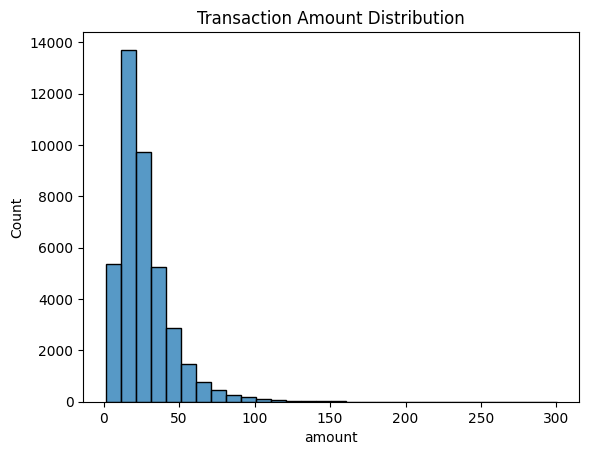

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
transactions = pd.read_csv("../data/raw/transactions.csv")
campaigns = pd.read_csv("../data/raw/campaign_outcomes.csv")

print(transactions.head())
print(campaigns.head())

# Example: Plot transaction frequency
sns.histplot(transactions['amount'], bins=30)
plt.title("Transaction Amount Distribution")
plt.show()


Transaction Per Customer

Transactions columns: ['customer_id', 'tx_date', 'amount', 'category', 'channel']
Campaign columns: ['customer_id', 'treatment', 'converted', 'revenue']


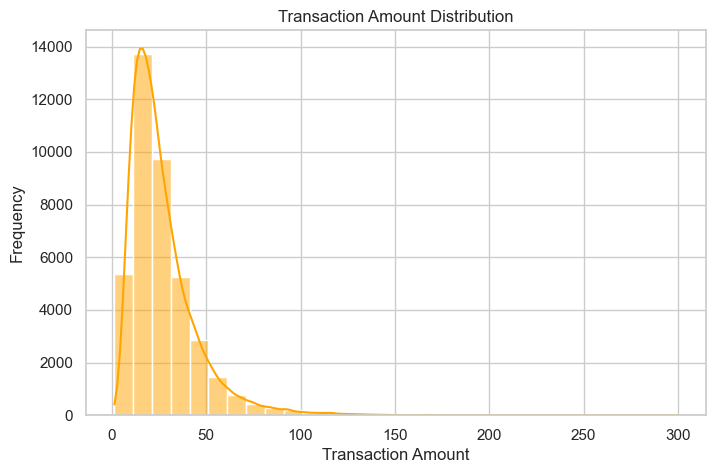

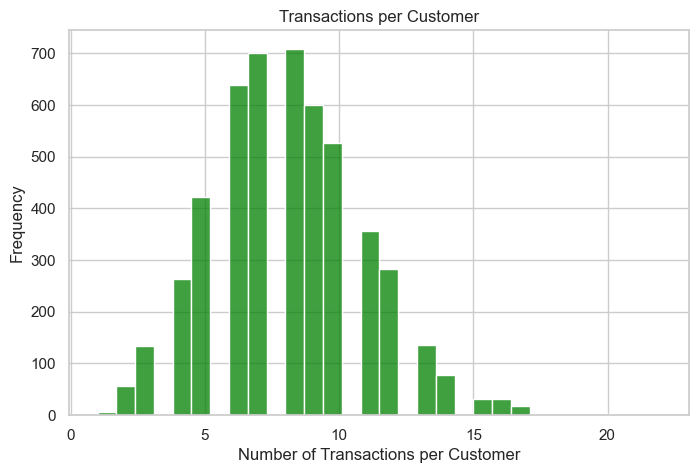

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
tx = pd.read_csv("../data/raw/transactions.csv")
camp = pd.read_csv("../data/raw/campaign_outcomes.csv")

# Check column names
print("Transactions columns:", tx.columns.tolist())
print("Campaign columns:", camp.columns.tolist())

# ---- EDA on transactions ----
# Adjust column names if needed
cust_col = [c for c in tx.columns if "cust" in c.lower()][0]   # finds customer column
amt_col = [c for c in tx.columns if "amount" in c.lower()][0]  # finds amount column

# Set seaborn style
sns.set(style="whitegrid")

# --- Transaction Amount Distribution ---
plt.figure(figsize=(8,5))
sns.histplot(tx["amount"], bins=30, color="orange", kde=True)
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Transaction Amount Distribution")
plt.show()

# --- Transactions per Customer ---
tx_per_customer = tx.groupby("customer_id")["amount"].count()
plt.figure(figsize=(8,5))
sns.histplot(tx_per_customer, bins=30, color="green", kde=False)
plt.xlabel("Number of Transactions per Customer")
plt.ylabel("Frequency")
plt.title("Transactions per Customer")
plt.show()


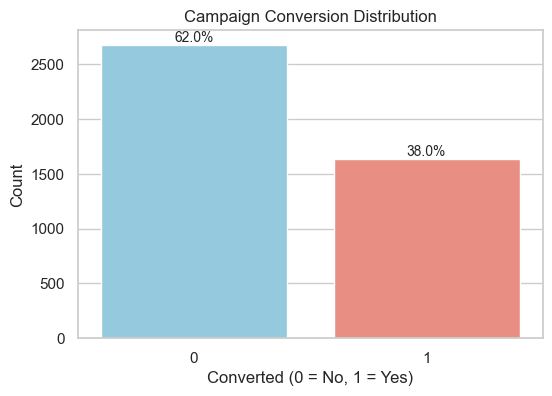

In [17]:
plt.figure(figsize=(6,4))
ax = sns.countplot(
    data=camp,
    x="converted",
    hue="converted",   # use x as hue
    palette={0: "skyblue", 1: "salmon"},
    legend=False
)

# Add labels
total = len(camp)
for p in ax.patches:
    count = int(p.get_height())
    percentage = f"{100 * count / total:.1f}%"
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title("Campaign Conversion Distribution")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

compare conversion between treatment vs control groups and then build a predictive model (CLV or conversion likelihood) to show business impact.

In [24]:
import os

print("Current working directory:", os.getcwd())
print("CSV files found here:")
for f in os.listdir():
    if f.endswith(".csv"):
        print(" -", f)


Current working directory: C:\Users\mukha\Downloads\marketing-analytics-clv-uplift\notebooks
CSV files found here:


In [26]:
import pandas as pd
from pathlib import Path

# Correct data folder
data_dir = Path(r"C:\Users\mukha\Downloads\marketing-analytics-clv-uplift\data\raw")

# Look for transaction + campaign CSVs
tx_file = next((p for p in data_dir.glob("**/*transactions*.csv")), None)
camp_file = next((p for p in data_dir.glob("**/*campaign*.csv")), None)

if tx_file is None or camp_file is None:
    raise FileNotFoundError(f"Could not find files in {data_dir}. Found tx={tx_file}, camp={camp_file}")

print(f"Using:\n - Transactions: {tx_file}\n - Campaign: {camp_file}")

# --- Load CSVs safely ---
# Preview transaction file to detect correct date column
tx_preview = pd.read_csv(tx_file, nrows=5)
date_cols = [c for c in ["tx_date", "date", "transaction_date"] if c in tx_preview.columns]

tx = pd.read_csv(tx_file, parse_dates=date_cols, low_memory=False)
camp = pd.read_csv(camp_file)

print("Loaded shapes:", tx.shape, camp.shape)


Using:
 - Transactions: C:\Users\mukha\Downloads\marketing-analytics-clv-uplift\data\raw\transactions.csv
 - Campaign: C:\Users\mukha\Downloads\marketing-analytics-clv-uplift\data\raw\campaign_outcomes.csv
Loaded shapes: (40331, 5) (4318, 4)


In [27]:
# Cell 2 — normalize and ensure required columns exist
tx.columns = tx.columns.str.lower()
camp.columns = camp.columns.str.lower()

required_camp = {"customer_id","treatment","converted"}
if not required_camp.issubset(set(camp.columns)):
    raise KeyError(f"campaign file is missing required columns. Found: {camp.columns.tolist()}")

# ensure numeric 0/1 flags
camp["treatment"] = camp["treatment"].astype(int)
camp["converted"] = camp["converted"].astype(int)

print("Campaign sample:\n", camp.head(5))


Campaign sample:
    customer_id  treatment  converted  revenue
0         3634          1          0     0.00
1         4119          1          0     0.00
2         4583          1          0     0.00
3         4672          1          0     0.00
4         2599          1          1    57.98


In [28]:
# Cell 3 — compute group stats + CIs
z_95 = 1.96

summary = camp.groupby("treatment").agg(
    n=("converted","count"),
    convs=("converted","sum")
).reset_index().sort_values("treatment")

summary["rate"] = summary["convs"] / summary["n"]
# standard error and 95% CI (Wald)
summary["se"] = np.sqrt(summary["rate"] * (1 - summary["rate"]) / summary["n"])
summary["ci_low"] = (summary["rate"] - z_95 * summary["se"]).clip(0,1)
summary["ci_high"] = (summary["rate"] + z_95 * summary["se"]).clip(0,1)

summary_formatted = summary.copy()
summary_formatted["rate%"] = (summary_formatted["rate"] * 100).round(2)
summary_formatted["95% CI"] = summary_formatted.apply(lambda r: f"{r['ci_low']*100:.2f}%–{r['ci_high']*100:.2f}%", axis=1)

summary_formatted[["treatment","n","convs","rate%","95% CI"]]


,treatment,n,convs,rate%,95% CI
0,0,2159,731,33.86,31.86%–35.85%
1,1,2159,908,42.06,39.97%–44.14%


In [29]:
# Cell 4 — z-test for difference in proportions (two-sided)
row_t = summary[summary["treatment"]==1].iloc[0]
row_c = summary[summary["treatment"]==0].iloc[0]

p1, n1 = row_t["rate"], row_t["n"]
p2, n2 = row_c["rate"], row_c["n"]
diff = p1 - p2

# pooled prop and SE
p_pool = (row_t["convs"] + row_c["convs"]) / (n1 + n2)
se_pool = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
z_score = diff / se_pool
# two-sided p-value using erf (no external libs needed)
from math import erf, sqrt
p_value = 2 * (1 - 0.5 * (1 + erf(abs(z_score) / sqrt(2))))

print(f"Treatment rate = {p1:.4f}  | Control rate = {p2:.4f}")
print(f"Difference (t - c) = {diff:.4f}  ({diff*100:.2f} percentage points)")
print(f"z = {z_score:.3f}  | two-sided p-value = {p_value:.4g}")


Treatment rate = 0.4206  | Control rate = 0.3386
Difference (t - c) = 0.0820  (8.20 percentage points)
z = 5.551  | two-sided p-value = 2.847e-08


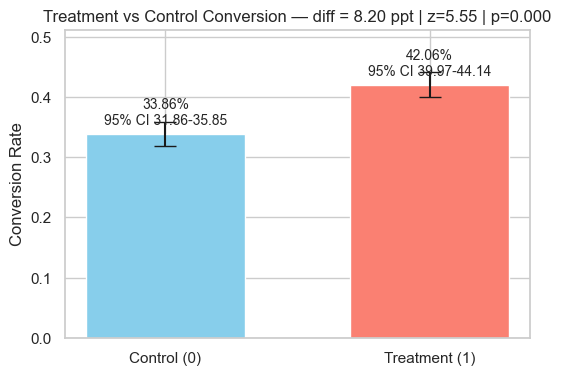

2.8471535795659975e-08


In [31]:
# Cell 5 — plot conversion rates with 95% CI and stats in the title
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6,4))

# order by treatment (0 then 1)
summary_plot = summary.sort_values("treatment")
x = np.arange(len(summary_plot))
rates = summary_plot["rate"].values
ci_low = summary_plot["ci_low"].values
ci_high = summary_plot["ci_high"].values
err_lower = rates - ci_low
err_upper = ci_high - rates
yerr = np.vstack([err_lower, err_upper])

colors = ["skyblue","salmon"]  # control, treatment
ax.bar(x, rates, color=colors, yerr=yerr, capsize=8, width=0.6)
ax.set_xticks(x)
ax.set_xticklabels(["Control (0)", "Treatment (1)"])
ax.set_ylim(0, max(ci_high.max()+0.07, rates.max()+0.08))

# annotate percentages + CIs on bars
for i, row in summary_plot.reset_index().iterrows():
    rr = row["rate"]
    cl = row["ci_low"]
    ch = row["ci_high"]
    ax.text(i, rr + 0.01, f"{rr*100:.2f}%\n95% CI {cl*100:.2f}-{ch*100:.2f}", ha='center', va='bottom', fontsize=10)

ax.set_ylabel("Conversion Rate")
ax.set_title(f"Treatment vs Control Conversion — diff = {diff*100:.2f} ppt | z={z_score:.2f} | p={p_value:.3f}")
plt.show()
print(p_value)


This is extremely small, way below 0.05.

The difference in conversion rates between treatment and control groups is statistically significant.

In other words, the marketing campaign had a real positive effect on conversions, not just random chance.